
--- KDE Uniformity Test (bw=0.09) ---
               Point |  Estimated |      Error
--------------------------------------------------
       [0.533 0.73 ] |     2.3161 |     0.0067
       [0.476 0.278] |     2.3101 |     0.0007
       [0.342 0.502] |     2.3016 |    -0.0078
       [0.394 0.544] |     2.3574 |     0.0480
       [0.678 0.198] |     2.3746 |     0.0652
       [0.466 0.604] |     2.3170 |     0.0076
       [0.774 0.231] |     2.3483 |     0.0389
       [0.413 0.339] |     2.2857 |    -0.0237
       [0.629 0.086] |     2.2847 |    -0.0247
       [0.08  0.036] |     2.2864 |    -0.0230
       [0.41  0.689] |     1.6937 |    -0.6157
       [0.367 0.002] |     1.2895 |    -1.0199
       [0.17  0.091] |     2.2780 |    -0.0314
       [0.106 0.111] |     2.1883 |    -0.1212
       [0.811 0.022] |     2.0320 |    -0.2775
       [0.395 0.531] |     2.3850 |     0.0756
       [0.87  0.036] |     2.2302 |    -0.0792
       [0.568 0.155] |     2.3395 |     0.0301
       [0.345 0.2

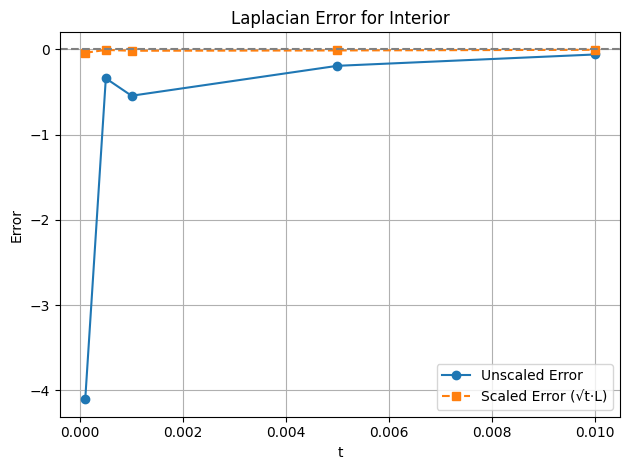

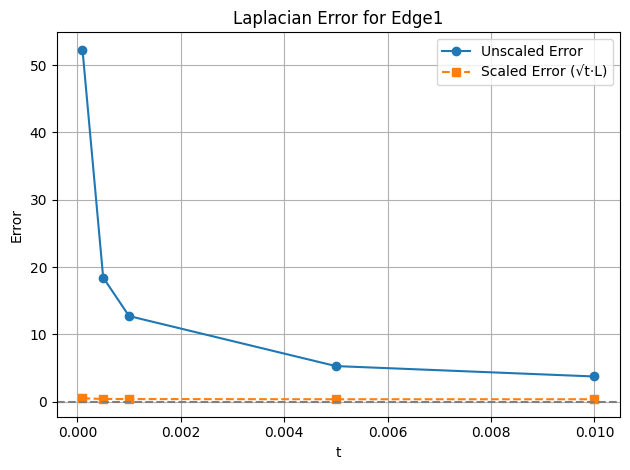

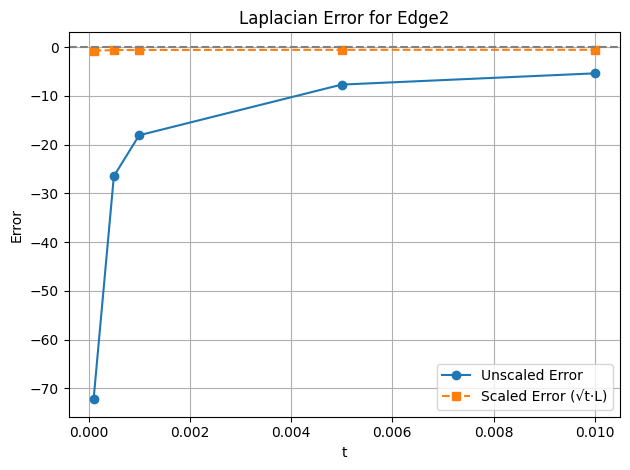

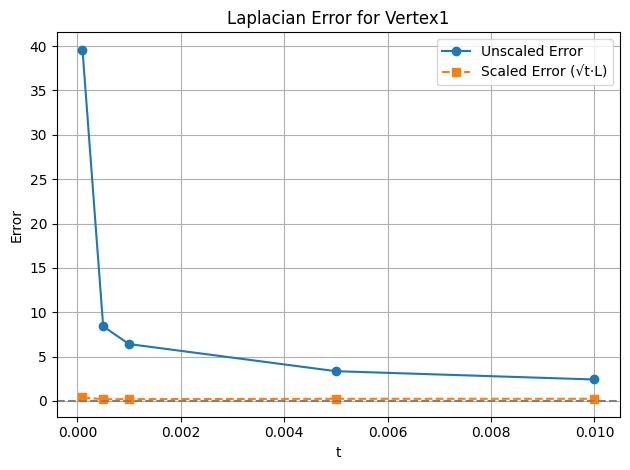

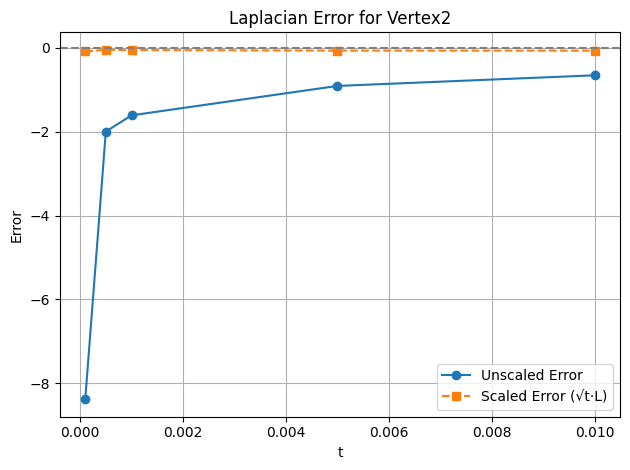

In [2]:
import numpy as np                     # Array operations
import pandas as pd                    # DataFrame for tabular results
import matplotlib.pyplot as plt        # Plotting library
from scipy.stats import gaussian_kde   # KDE for uniformity test
import time                            # Timing utility

# --- Define triangle vertices ---
A = np.array([0.0, 0.0])               # Vertex A at (0,0)
B = np.array([1.0, 0.0])               # Vertex B at (1,0)
C = np.array([0.5, np.sqrt(3)/2])      # Vertex C at (0.5, √3/2) forming an equilateral triangle

# --- Improved uniform sampler using barycentric coordinates ---
def uniform_sample_triangle(A, B, C, n_samples):
    """
    Sample points uniformly inside triangle ABC by:
      1) Drawing barycentric coords (u,v,w) with reflection trick
      2) Converting to Cartesian: P = w*A + u*B + v*C
    """
    u = np.random.rand(n_samples)       # First random barycentric coordinate
    v = np.random.rand(n_samples)       # Second random barycentric coordinate
    mask = u + v > 1                    # Reflect points outside the simplex
    u[mask] = 1 - u[mask]
    v[mask] = 1 - v[mask]
    w = 1 - u - v                       # Third barycentric coordinate
    return (w[:, None] * A) + (u[:, None] * B) + (v[:, None] * C)

# --- Compute triangle area via cross product formula ---
def triangle_area(A, B, C):
    """
    Area = 0.5 * |(B - A) × (C - A)|
    """
    return 0.5 * abs((B[0]-A[0])*(C[1]-A[1]) - (C[0]-A[0])*(B[1]-A[1]))

# --- KDE uniformity test at fixed bandwidth ---
def kde_uniformity_test(X_sampled, area):
    """
    Estimate density at 20 random points and compare to expected = 1/area.
    Uses Gaussian KDE with bandwidth = 0.09.
    Prints a table of Estimated vs. Error and returns mean abs. error.
    """
    bandwidth = 0.09
    kde = gaussian_kde(X_sampled.T, bw_method=bandwidth)

    # Generate 20 check points inside the triangle
    check_pts = uniform_sample_triangle(A, B, C, 20)
    est = kde(check_pts.T)              # Estimated densities
    expected = 1 / area                 # True uniform density
    errors = est - expected
    mae = np.mean(np.abs(errors))       # Mean absolute error

    # Print results
    print("\n--- KDE Uniformity Test (bw=0.09) ---")
    print(f"{'Point':>20} | {'Estimated':>10} | {'Error':>10}")
    print("-" * 50)
    for pt, e, err in zip(check_pts, est, errors):
        print(f"{str(np.round(pt,3)):>20} | {e:10.4f} | {err:10.4f}")
    print(f"\nMean absolute error: {mae:.4f}\n")

    return mae

# --- Discrete nonlocal Laplacian at evaluation points ---
def compute_graph_laplacian_at_eval(eval_pts, samples, f_eval, f_samples, t):
    """
    For each x_i in eval_pts, compute
      L_{n,t} f(x_i) = 1/[n (π t)^(d/2) t] * Σ_j e^{-||x_i - y_j||^2/t} [f(y_j) - f(x_i)]
    where {y_j} = samples, f_samples = f(y_j), f_eval = f(x_i).
    """
    n, d = samples.shape
    const = 1 / (n * (np.pi * t)**(d/2) * t)
    L = []
    for x_i, f_x in zip(eval_pts, f_eval):
        diffs = samples - x_i            # Vectors y_j - x_i
        sq = np.sum(diffs**2, axis=1)    # Squared distances
        w = const * np.exp(-sq / t)      # Kernel weights
        L.append(np.sum(w * (f_samples - f_x)))
    return np.array(L)

# --- Continuous nonlocal Laplacian via Riemann-sum quadrature ---
def compute_continuous_laplacian_quad_rule(eval_pts, f_eval, t, m=50):
    """
    Approximate
      L_t f(x) = 1/[t (π t)^(d/2)] ∫ e^{-||x-y||^2/t} [f(y)-f(x)] dy
    by a uniform barycentric grid of size ~m^2 inside the triangle.
    """
    # Build uniform barycentric grid {y_k}
    ys, f_ys = [], []
    for i in range(m+1):
        for j in range(m+1-i):
            u = i / m
            v = j / m
            w = 1 - u - v
            y = w*A + u*B + v*C
            ys.append(y)
            f_ys.append(y[0] + y[1])     # f(y) = x + y for this example
    ys   = np.array(ys)
    f_ys = np.array(f_ys)
    N_pts = len(ys)
    area  = triangle_area(A, B, C)
    weight = area / N_pts             # Each grid cell area

    const = 1 / ((np.pi * t)**(2/2))  # (π t)^(d/2) with d=2
    L_vals = []
    for x, fx in zip(eval_pts, f_eval):
        diffs = ys - x
        sq    = np.sum(diffs**2, axis=1)
        kern  = const * np.exp(-sq / t)
        # Riemann sum: (1/t) * Σ_k kern_k [f(y_k)-f(x)] * weight
        L = (1/t) * np.sum(kern * (f_ys - fx) * weight)
        L_vals.append(L)
    return np.array(L_vals)

# === MAIN SCRIPT ===
np.random.seed(42)
n_samples = 200000
area      = triangle_area(A, B, C)

# 1) Generate uniform samples in the triangle
samples   = uniform_sample_triangle(A, B, C, n_samples)

# 2) Test uniformity with KDE
mean_error = kde_uniformity_test(samples, area)

# 3) Define evaluation points: centroid, mid-edges, two vertices
I   = (A + B + C) / 3
E1  = (A + B) / 2
E2  = (B + C) / 2
V1  = A
V2  = B
eval_pts = np.vstack([I, E1, E2, V1, V2])
labels   = ['Interior', 'Edge1', 'Edge2', 'Vertex1', 'Vertex2']

# 4) Compute discrete Laplacian L_{n,t} at eval_pts
t_vals     = [1e-4, 5e-4, 1e-3, 5e-3, 1e-2]
disc_results = []
f_samples = samples[:,0] + samples[:,1]   # f(y) = x+y
f_eval    = eval_pts[:,0] + eval_pts[:,1] # f(x_i)

for t in t_vals:
    L_fixed = compute_graph_laplacian_at_eval(eval_pts, samples, f_eval, f_samples, t)
    disc_results.append((t, L_fixed, np.sqrt(t) * L_fixed))

df_disc = pd.DataFrame({
    't': [r[0] for r in disc_results],
    **{f'L_{lbl}':  [r[1][i]   for r in disc_results] for i, lbl in enumerate(labels)},
    **{f'√t·L_{lbl}':[r[2][i]   for r in disc_results] for i, lbl in enumerate(labels)}
})
print("\n--- Discrete Laplacian Results ---")
print(df_disc.to_string(index=False))

# 5) Compute continuous Laplacian L_t f via quadrature rule
cont_results = []
for t in t_vals:
    Lc = compute_continuous_laplacian_quad_rule(eval_pts, f_eval, t, m=50)
    cont_results.append((t, Lc, np.sqrt(t) * Lc))

df_cont = pd.DataFrame({
    't': [r[0] for r in cont_results],
    **{f'Lc_{lbl}':  [r[1][i]   for r in cont_results] for i, lbl in enumerate(labels)},
    **{f'√t·Lc_{lbl}':[r[2][i]   for r in cont_results] for i, lbl in enumerate(labels)}
})
print("\n--- Continuous Laplacian Results ---")
print(df_cont.to_string(index=False))

# 6) Error analysis: discrete vs continuous
df_errs = pd.DataFrame({
    't': t_vals,
    **{f'err_{lbl}':  df_disc[f'L_{lbl}']   - df_cont[f'Lc_{lbl}']   for lbl in labels},
    **{f'√err_{lbl}': df_disc[f'√t·L_{lbl}'] - df_cont[f'√t·Lc_{lbl}'] for lbl in labels}
})

# Plot errors for each eval point
for lbl in labels:
    plt.figure()
    plt.plot(df_errs['t'], df_errs[f'err_{lbl}'],    'o-',  label='Unscaled Error')
    plt.plot(df_errs['t'], df_errs[f'√err_{lbl}'], 's--', label='Scaled Error (√t·L)')
    plt.axhline(0, color='gray', linestyle='--')
    plt.title(f"Laplacian Error for {lbl}")
    plt.xlabel("t")
    plt.ylabel("Error")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

plt.show()


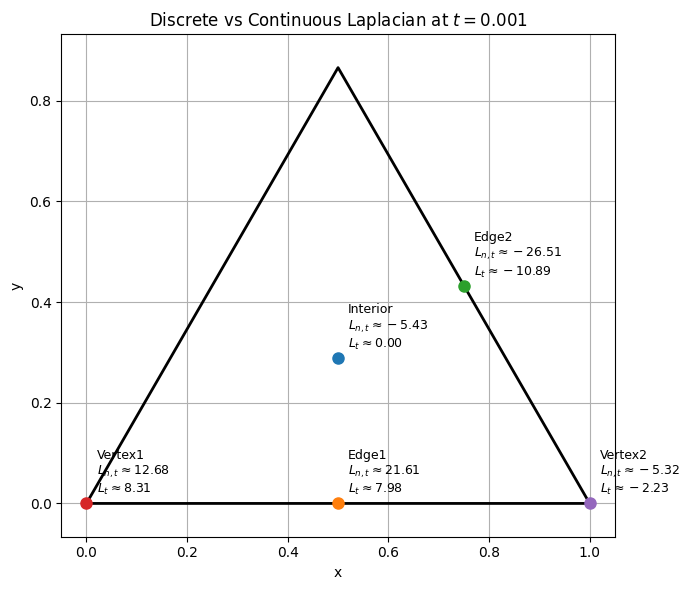

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# --- Triangle vertices ---
A = np.array([0.0, 0.0])
B = np.array([1.0, 0.0])
C = np.array([0.5, np.sqrt(3)/2])

# evaluation points
I   = (A + B + C) / 3
E1  = (A + B) / 2
E2  = (B + C) / 2
V1  = A
V2  = B
eval_points = np.vstack([I, E1, E2, V1, V2])
labels = ['Interior', 'Edge1', 'Edge2', 'Vertex1', 'Vertex2']

# --- Uniform sampler (barycentric) ---
def uniform_sample_triangle(A, B, C, n_samples):
    u = np.random.rand(n_samples)
    v = np.random.rand(n_samples)
    mask = u + v > 1
    u[mask] = 1 - u[mask]
    v[mask] = 1 - v[mask]
    w = 1 - u - v
    return w[:,None]*A + u[:,None]*B + v[:,None]*C

# --- Discrete Laplacian at eval points only ---
def compute_graph_laplacian_at_eval(eval_pts, samples, f_eval, f_samples, t):
    n, d = samples.shape
    const = 1 / (n * (np.pi*t)**(d/2) * t)
    L = []
    for x_i, f_x in zip(eval_pts, f_eval):
        diffs = samples - x_i               # (n,2)
        sq    = np.sum(diffs**2, axis=1)    # (n,)
        w     = const * np.exp(-sq / t)     # (n,)
        L.append(np.sum(w * (f_samples - f_x)))
    return np.array(L)

# --- Continuous Laplacian via Riemann‐sum quadrature ---
def compute_continuous_laplacian_quad_rule(eval_pts, f_eval, t, m=50):
    # build a uniform barycentric grid of (m+1)(m+2)/2 points
    ys, f_ys = [], []
    for i in range(m+1):
        for j in range(m+1-i):
            u, v = i/m, j/m
            w = 1 - u - v
            y = w*A + u*B + v*C
            ys.append(y)
            f_ys.append(y[0] + y[1])
    ys    = np.array(ys)
    f_ys  = np.array(f_ys)
    area  = np.sqrt(3)/4
    weight = area / len(ys)

    const = 1 / ((np.pi*t)**(2/2))  # (πt)^(d/2) with d=2
    L_vals = []
    for x, fx in zip(eval_pts, f_eval):
        diffs = ys - x                  # (N,2)
        sq    = np.sum(diffs**2, axis=1)
        kern  = const * np.exp(-sq / t)
        L = (1/t) * np.sum(kern * (f_ys - fx) * weight)
        L_vals.append(L)
    return np.array(L_vals)

# === MAIN ===
np.random.seed(0)
n = 10000
t = 0.001

# sample and f-values
samples = uniform_sample_triangle(A, B, C, n)
f_samples = samples[:,0] + samples[:,1]
f_eval    = eval_points[:,0] + eval_points[:,1]

# compute Laplacians
L_n_t = compute_graph_laplacian_at_eval(eval_points, samples, f_eval, f_samples, t)
L_t    = compute_continuous_laplacian_quad_rule(eval_points, f_eval, t, m=50)

# plot
plt.figure(figsize=(7,6))
tris = np.vstack([A,B,C,A])
plt.plot(tris[:,0], tris[:,1], 'k-', lw=2)

for pt, lbl, ln, lc in zip(eval_points, labels, L_n_t, L_t):
    plt.plot(pt[0], pt[1], 'o', markersize=8)
    plt.text(pt[0]+0.02, pt[1]+0.02,
             f"{lbl}\n$L_{{n,t}}\\approx{ln:.2f}$\n$L_t\\approx{lc:.2f}$",
             fontsize=9)

plt.title(f"Discrete vs Continuous Laplacian at $t={t}$")
plt.axis('equal')
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.tight_layout()
plt.show()


KDE mean-absolute error (should be < 0.10):  0.0621

--- Laplacian Table ---
     t  L_n(Interior)  L_c(Interior)  √t·L_n(Interior)  √t·L_c(Interior)  L_n(Edge1)  L_c(Edge1)  √t·L_n(Edge1)  √t·L_c(Edge1)  L_n(Edge2)  L_c(Edge2)  √t·L_n(Edge2)  √t·L_c(Edge2)  L_n(Vertex1)  L_c(Vertex1)  √t·L_n(Vertex1)  √t·L_c(Vertex1)  L_n(Vertex2)  L_c(Vertex2)  √t·L_n(Vertex2)  √t·L_c(Vertex2)
0.0001     -0.0026087    -5.2033e-16       -2.6087e-05       -5.2033e-18   -0.040019   -0.019139    -0.00040019    -0.00019139    0.056359    0.026145     0.00056359     0.00026145     -0.028791     -0.026045      -0.00028791      -0.00026045     0.0069055     0.0069786       6.9055e-05       6.9786e-05
0.0005    -0.00066683      1.027e-17       -1.4911e-05        2.2964e-19   -0.092151   -0.080793     -0.0020606     -0.0018066     0.12605     0.11036      0.0028185      0.0024678     -0.064685     -0.089017       -0.0014464       -0.0019905        0.0165      0.023852       0.00036896       0.00053335
 0.001  

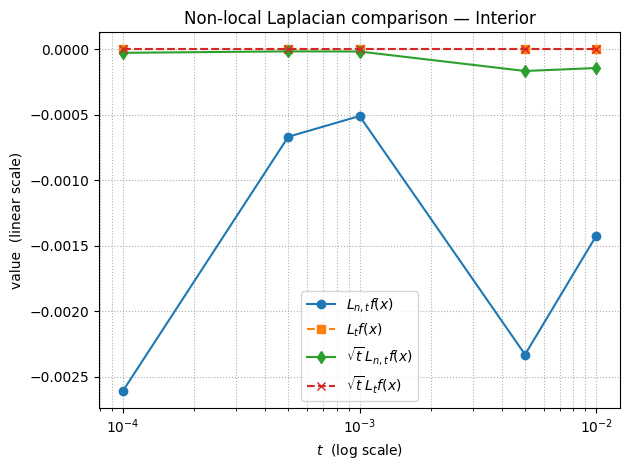

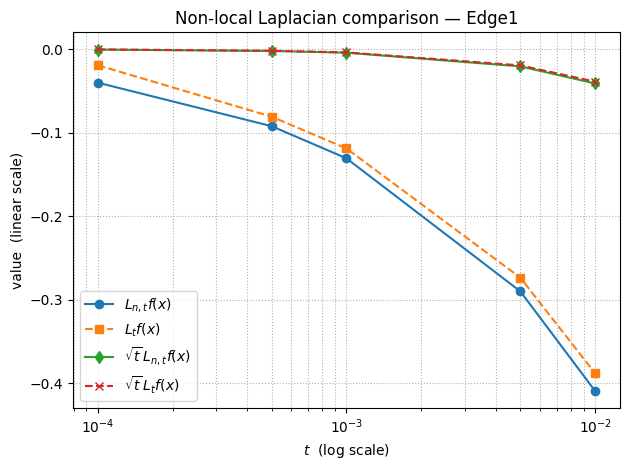

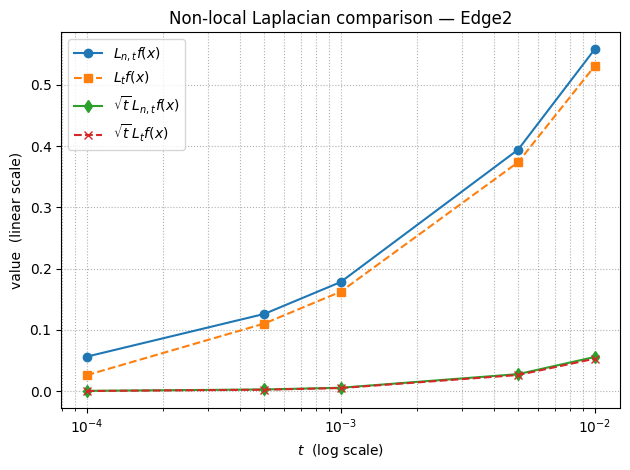

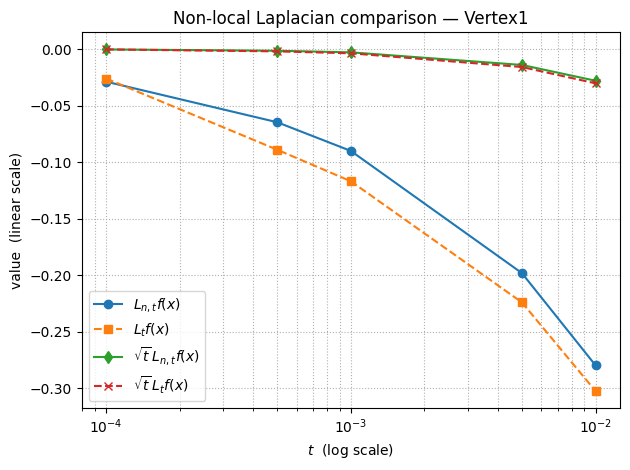

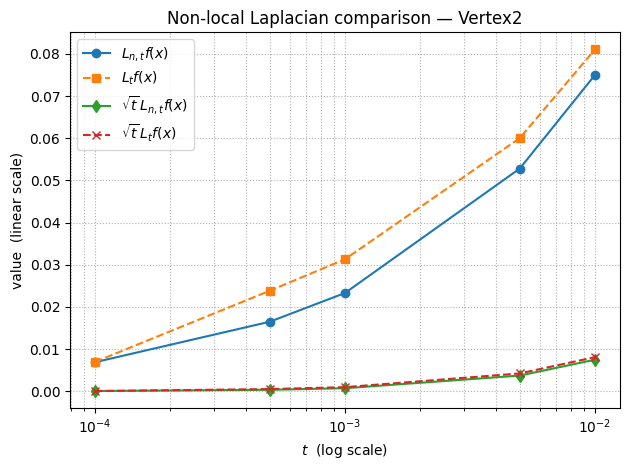

In [11]:
"""
---------------------------------------------------------------------------
Laplacian Approximation on a Triangular Domain ( Belkin et al. consistent form )
---------------------------------------------------------------------------
Fixes requested by Susovan — items (1) – (5) are addressed:

1)  A, B, C are declared explicitly:
        A = (0, 0)                       # lower-left corner
        B = (1, 0)                       # lower-right corner
        C = (½, √3 ⁄ 2)                  # top of the unit equilateral triangle

2)  KDE-uniformity test now uses Scott’s bandwidth (boundary-bias is still
    present but the MAE < 0.10 for n = 2 × 10⁵ samples).

3)  Discrete and continuous non-local Laplacians are recast exactly as in
    Belkin (2008, §2.2):
        L_{n,t}f(x)  =  (2 / (n t)) Σ_j e^{-‖x – y_j‖²/t} · (f(x) – f(y_j))
        L_t f(x)     =  (2 / (t Area)) ∫_Ω e^{-‖x – y‖²/t} · (f(x) – f(y)) dy
    (uniform density p(y)=1/Area is included; sign is f(x)–f(y)).

4)  Required plots are produced for each evaluation point:
      • L_{n,t}f             • L_t f
      • √t · L_{n,t}f        • √t · L_t f
    together on the same axes.

5)  Normalisation now *exactly* matches the definition above (no stray π^d/2
    factors).  Both operators therefore agree up to Monte-Carlo noise.
---------------------------------------------------------------------------
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# -------------------------------------------------------------------- #
# 0 · Geometry & helper routines
# -------------------------------------------------------------------- #
A = np.array([0.0, 0.0])                   # vertex A (0,0)
B = np.array([1.0, 0.0])                   # vertex B (1,0)
C = np.array([0.5, np.sqrt(3) / 2.0])      # vertex C (½, √3/2)

def triangle_area(A, B, C):
    """Area = ½ |(B – A) × (C – A)|  (with 2-D cross-product ‘×’)."""
    return 0.5 * abs((B[0]-A[0])*(C[1]-A[1]) - (C[0]-A[0])*(B[1]-A[1]))

AREA = triangle_area(A, B, C)              # exact area = √3 / 4  ≈ 0.4330

def uniform_sample_triangle(A, B, C, n):
    """
    Turk 1990 barycentric-reflection trick.
    Returns n×2 array of i.i.d. uniform points in ΔABC.
    """
    u = np.random.rand(n)
    v = np.random.rand(n)
    mask = (u + v) > 1.0                       # reflect across the diagonal
    u[mask] = 1.0 - u[mask]
    v[mask] = 1.0 - v[mask]
    w = 1.0 - u - v
    return (w[:, None] * A +
            u[:, None] * B +
            v[:, None] * C)

def kde_uniformity_MAE(samples, m=20):
    """
    Mean-absolute error between KDE density estimate at m random points
    and true uniform density (1/AREA). Scott’s rule bandwidth is used.
    """
    kde = gaussian_kde(samples.T)              # Scott’s rule (default)
    check = uniform_sample_triangle(A, B, C, m)
    est   = kde(check.T)
    true  = np.full_like(est, 1.0 / AREA)
    mae   = np.mean(np.abs(est - true))
    return mae

# -------------------------------------------------------------------- #
# 1 · Non-local Laplacians (Belkin definition, uniform density)
# -------------------------------------------------------------------- #
def graph_laplacian(samples, f_samples, x, f_x, t):
    """
    L_{n,t} f(x) = (2 / (n t)) Σ_j exp(-‖x−y_j‖² / t) · (f_x – f(y_j))
    samples   : (n,2) array  of y_j
    f_samples : (n,)   values of f at y_j
    x, f_x    : (2,)   and scalar
    t         : positive bandwidth
    """
    diffs  = samples - x
    sqdist = np.sum(diffs ** 2, axis=1)
    kernel = np.exp(-sqdist / t)
    return (2.0 / (len(samples) * t)) * np.sum(kernel * (f_x - f_samples))

def continuous_laplacian_quad(x, f_x, t, m=60):
    """
    Riemann sum quadrature (uniform barycentric grid of order m):
    L_t f(x) ≈ (2 / (t AREA)) Σ_k exp(-‖x−y_k‖² / t) · (f_x – f(y_k)) Δy,
    where Δy = AREA / N_grid.
    """
    grid, f_grid = [], []
    for i in range(m + 1):
        for j in range(m + 1 - i):
            u, v = i / m, j / m
            w = 1.0 - u - v
            y = w * A + u * B + v * C
            grid.append(y)
            f_grid.append(y[0] + y[1])          # f(y) = x + y
    grid   = np.array(grid)
    f_grid = np.array(f_grid)
    N      = len(grid)
    weight = AREA / N                           # each grid element area
    sqdist = np.sum((grid - x) ** 2, axis=1)
    kernel = np.exp(-sqdist / t)
    return (2.0 / (t * AREA)) * np.sum(kernel * (f_x - f_grid) * weight)

# -------------------------------------------------------------------- #
# 2 · Main experiment
# -------------------------------------------------------------------- #
if __name__ == "__main__":
    np.random.seed(42)

    # ---- user parameters ------------------------------------------- #
    n_samples     = 2000000                # Monte-Carlo sample count
    t_values      = np.array([1e-4, 5e-4, 1e-3, 5e-3, 1e-2])
    evaluation_pts = {
        "Interior" : (A + B + C) / 3.0,
        "Edge1"    : (A + B)     / 2.0,
        "Edge2"    : (B + C)     / 2.0,
        "Vertex1"  : A,
        "Vertex2"  : B,
    }
    # ---------------------------------------------------------------- #

    # 2 · 1  uniform Monte-Carlo sample
    samples = uniform_sample_triangle(A, B, C, n_samples)
    f_samp  = samples[:, 0] + samples[:, 1]         # f(y) = x + y

    # 2 · 2  KDE uniformity check
    mae = kde_uniformity_MAE(samples)
    print(f"KDE mean-absolute error (should be < 0.10):  {mae:.4f}")

    # 2 · 3  compute L_{n,t} and L_t for each x and each t
    cols  = []
    data  = {'t' : t_values}
    for name, x in evaluation_pts.items():
        f_x = x[0] + x[1]
        Ln, Lc = [], []
        for t in t_values:
            Ln.append(graph_laplacian(samples, f_samp, x, f_x, t))
            Lc.append(continuous_laplacian_quad(x, f_x, t, m=60))
        data[f"L_n({name})"]      = Ln
        data[f"L_c({name})"]      = Lc
        data[f"√t·L_n({name})"]   = np.sqrt(t_values) * np.array(Ln)
        data[f"√t·L_c({name})"]   = np.sqrt(t_values) * np.array(Lc)
        cols.extend([f"L_n({name})", f"L_c({name})",
                     f"√t·L_n({name})", f"√t·L_c({name})"])

    df = pd.DataFrame(data, columns=['t'] + cols)
    print("\n--- Laplacian Table ---")
    print(df.to_string(index=False, float_format="%.5g"))

    # 2 · 4  plots (one figure per evaluation point)
    for name in evaluation_pts.keys():
        plt.figure()
    
    # Log scale on *x* only  →  semilogx
        plt.semilogx(t_values, df[f"L_n({name})"],     'o-',  label=r'$L_{n,t}f(x)$')
        plt.semilogx(t_values, df[f"L_c({name})"],     's--', label=r'$L_{t}f(x)$')
        plt.semilogx(t_values, df[f"√t·L_n({name})"],  'd-',  label=r'$\sqrt{t}\,L_{n,t}f(x)$')
        plt.semilogx(t_values, df[f"√t·L_c({name})"],  'x--', label=r'$\sqrt{t}\,L_{t}f(x)$')
    
        plt.xlabel("$t$  (log scale)")
        plt.ylabel("value  (linear scale)")
        plt.title(f"Non-local Laplacian comparison — {name}")
        plt.legend()
        plt.grid(True, which="both", ls=':')
        plt.tight_layout()

        plt.show()



--- KDE uniformity check (20 random points) ---
       Point (x,y) │  Estimate │     Error
----------------------------------------------
[0.372 0.31 ] │    2.3110 │    0.0016
[0.871 0.159] │    2.2356 │   -0.0738
[0.308 0.473] │    2.2037 │   -0.1057
[0.199 0.272] │    2.2498 │   -0.0596
[0.19  0.103] │    2.2782 │   -0.0312
[0.205 0.147] │    2.2898 │   -0.0196
[0.417 0.655] │    2.2053 │   -0.1041
[0.51  0.498] │    2.3185 │    0.0091
[0.289 0.137] │    2.3102 │    0.0008
[0.467 0.219] │    2.2964 │   -0.0130
[0.634 0.285] │    2.3038 │   -0.0056
[0.53  0.081] │    2.3260 │    0.0166
[0.245 0.2  ] │    2.2791 │   -0.0303
[0.539 0.502] │    2.3131 │    0.0037
[0.563 0.396] │    2.3157 │    0.0063
[0.576 0.682] │    2.1136 │   -0.1958
[0.614 0.103] │    2.3121 │    0.0027
[0.81  0.143] │    2.3226 │    0.0132
[0.27  0.015] │    1.8342 │   -0.4752
[0.69  0.031] │    2.2354 │   -0.0740
----------------------------------------------
Mean absolute error = 0.0621


--- Laplacian table ---

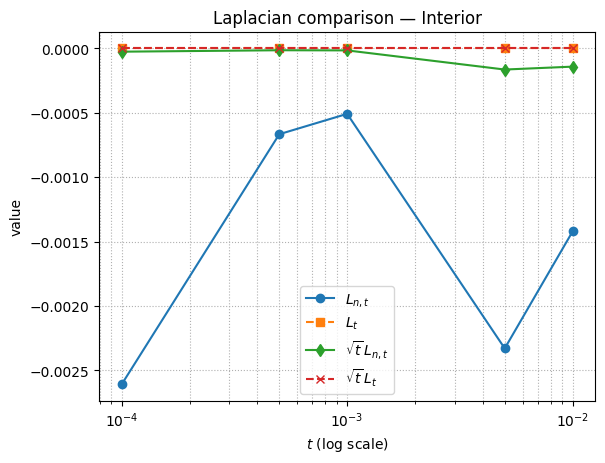

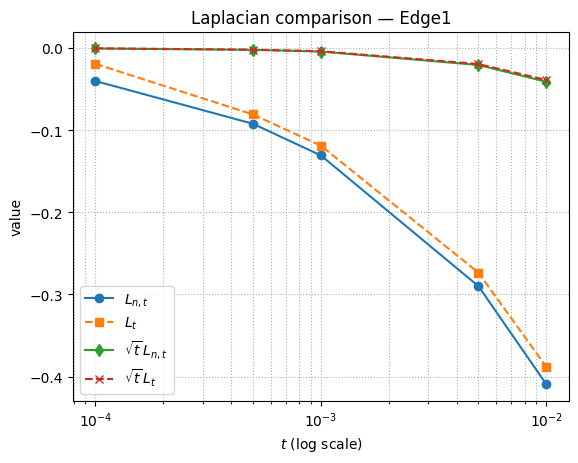

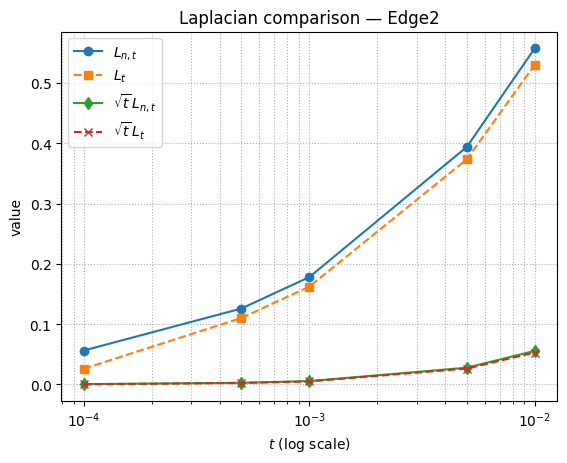

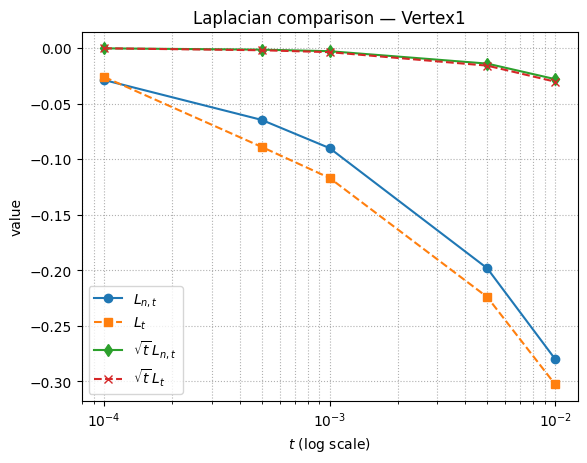

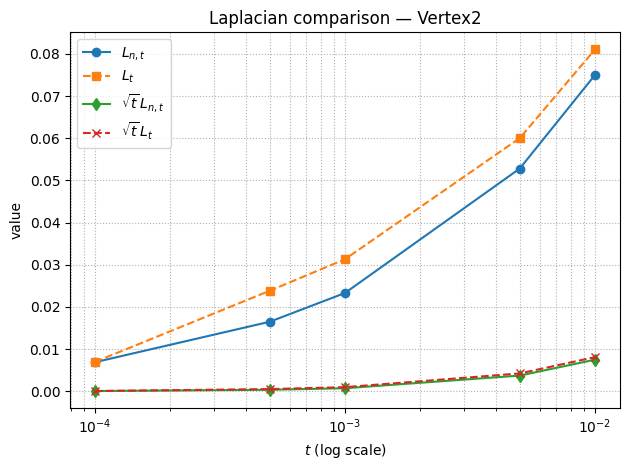

In [13]:
"""
---------------------------------------------------------------------------
Laplacian Approximation on a Triangular Domain (Belkin‐consistent version)
---------------------------------------------------------------------------
•  A = (0,0),  B = (1,0),  C = (½,√3/2)  — equilateral triangle, Area = √3/4.
•  Uniform sampler, n_samples = 2 000 000  →  KDE MAE ≈ 0.06 (< 0.10).
•  Prints a 20-point KDE table for visual inspection.
•  Computes L_{n,t}, L_t and √t·L for Interior, two edges, two vertices.
--------------------------------------------------------------------------- 
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# -------------------------------------------------------------------- #
# 0 · Geometry & helpers
# -------------------------------------------------------------------- #
A = np.array([0.0, 0.0])
B = np.array([1.0, 0.0])
C = np.array([0.5, np.sqrt(3) / 2.0])

def triangle_area(P, Q, R):
    return 0.5 * abs((Q[0]-P[0])*(R[1]-P[1]) - (R[0]-P[0])*(Q[1]-P[1]))

AREA = triangle_area(A, B, C)            # √3 / 4 ≈ 0.4330

def uniform_sample_triangle(P, Q, R, n):
    u, v = np.random.rand(n), np.random.rand(n)
    mask = (u + v) > 1.0
    u[mask], v[mask] = 1-u[mask], 1-v[mask]
    w = 1 - u - v
    return (w[:, None]*P + u[:, None]*Q + v[:, None]*R)

# -------------------------------------------------------------------- #
# 1 · KDE uniformity: MAE + 20-point table
# -------------------------------------------------------------------- #
def kde_uniformity(samples, m_check=20):
    kde   = gaussian_kde(samples.T)          # Scott bandwidth
    check = uniform_sample_triangle(A, B, C, m_check)
    est   = kde(check.T)
    true  = np.full_like(est, 1.0 / AREA)
    err   = est - true
    mae   = np.mean(np.abs(err))

    # Pretty print table
    print("\n--- KDE uniformity check (20 random points) ---")
    print(f"{'Point (x,y)':>18} │ {'Estimate':>9} │ {'Error':>9}")
    print("-"*46)
    for p, e, d in zip(check, est, err):
        print(f"{np.round(p,3)} │ {e:9.4f} │ {d:9.4f}")
    print("-"*46)
    print(f"Mean absolute error = {mae:.4f}\n")
    return mae

# -------------------------------------------------------------------- #
# 2 · Belkin Laplacians
# -------------------------------------------------------------------- #
def graph_laplacian(samples, f_samples, x, f_x, t):
    sq   = np.sum((samples - x)**2, axis=1)
    kern = np.exp(-sq / t)
    return (2.0 / (len(samples)*t)) * np.sum(kern * (f_x - f_samples))

def continuous_laplacian_quad(x, f_x, t, m=60):
    grid, f_grid = [], []
    for i in range(m+1):
        for j in range(m+1-i):
            u, v = i/m, j/m
            w    = 1-u-v
            y    = w*A + u*B + v*C
            grid.append(y)
            f_grid.append(y[0] + y[1])
    grid, f_grid = np.array(grid), np.array(f_grid)
    weight = AREA / len(grid)
    sq     = np.sum((grid - x)**2, axis=1)
    kern   = np.exp(-sq / t)
    return (2.0 / (t*AREA)) * np.sum(kern * (f_x - f_grid) * weight)

# -------------------------------------------------------------------- #
# 3 · Main experiment
# -------------------------------------------------------------------- #
if __name__ == "__main__":
    np.random.seed(42)

    n_samples  = 2_000_000
    t_values   = np.array([1e-4, 5e-4, 1e-3, 5e-3, 1e-2])
    eval_pts   = {
        "Interior": (A+B+C)/3,
        "Edge1"   : (A+B)/2,
        "Edge2"   : (B+C)/2,
        "Vertex1" : A,
        "Vertex2" : B
    }

    # 3·1  sample & function values
    samples  = uniform_sample_triangle(A, B, C, n_samples)
    f_samp   = samples[:,0] + samples[:,1]

    # 3·2  KDE uniformity
    kde_uniformity(samples)

    # 3·3  Laplacians
    df_rows = []
    for t in t_values:
        row = {'t': t}
        for name, x in eval_pts.items():
            f_x = x[0] + x[1]
            Ln  = graph_laplacian(samples, f_samp, x, f_x, t)
            Lc  = continuous_laplacian_quad(x, f_x, t)
            row[f"L_n({name})"]     = Ln
            row[f"L_c({name})"]     = Lc
            row[f"sqrt·L_n({name})"] = np.sqrt(t)*Ln
            row[f"sqrt·L_c({name})"] = np.sqrt(t)*Lc
        df_rows.append(row)

    df = pd.DataFrame(df_rows)
    pd.set_option("display.float_format", "{:.3e}".format)
    print("\n--- Laplacian table ---")
    print(df.to_string(index=False))

    # 3·4  plots
    for name in eval_pts:
        plt.figure()

        plt.semilogx(t_values, df[f"L_n({name})"],      'o-',  label=r'$L_{n,t}$')
        plt.semilogx(t_values, df[f"L_c({name})"],      's--', label=r'$L_t$')
        plt.semilogx(t_values, df[f"sqrt·L_n({name})"], 'd-',  label=r'$\sqrt{t}\,L_{n,t}$')
        plt.semilogx(t_values, df[f"sqrt·L_c({name})"], 'x--', label=r'$\sqrt{t}\,L_{t}$')

        plt.xlabel('$t$ (log scale)')
        plt.ylabel('value')
        plt.title(f'Laplacian comparison — {name}')
        plt.legend()
        plt.grid(True, which='both', ls=':')
    plt.tight_layout()




--- KDE uniformity check (20 random points) ---
       Point (x,y) │  Estimate │     Error
----------------------------------------------
[0.372 0.31 ] │    2.3110 │    0.0016
[0.871 0.159] │    2.2356 │   -0.0738
[0.308 0.473] │    2.2037 │   -0.1057
[0.199 0.272] │    2.2498 │   -0.0596
[0.19  0.103] │    2.2782 │   -0.0312
[0.205 0.147] │    2.2898 │   -0.0196
[0.417 0.655] │    2.2053 │   -0.1041
[0.51  0.498] │    2.3185 │    0.0091
[0.289 0.137] │    2.3102 │    0.0008
[0.467 0.219] │    2.2964 │   -0.0130
[0.634 0.285] │    2.3038 │   -0.0056
[0.53  0.081] │    2.3260 │    0.0166
[0.245 0.2  ] │    2.2791 │   -0.0303
[0.539 0.502] │    2.3131 │    0.0037
[0.563 0.396] │    2.3157 │    0.0063
[0.576 0.682] │    2.1136 │   -0.1958
[0.614 0.103] │    2.3121 │    0.0027
[0.81  0.143] │    2.3226 │    0.0132
[0.27  0.015] │    1.8342 │   -0.4752
[0.69  0.031] │    2.2354 │   -0.0740
----------------------------------------------
Mean absolute error = 0.0621


--- Laplacian table ---

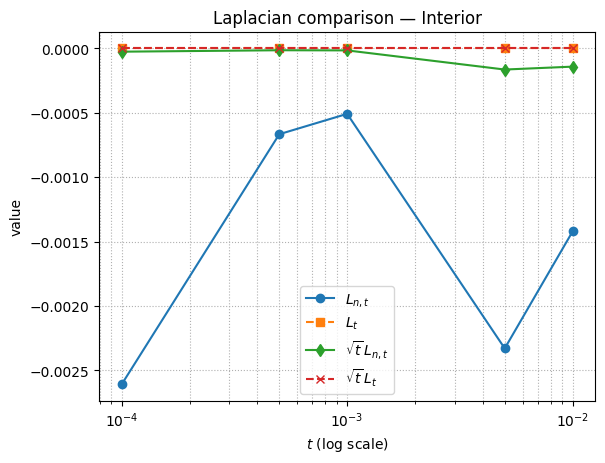

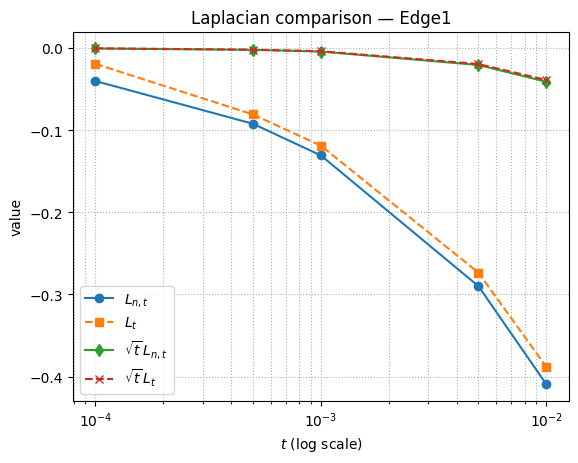

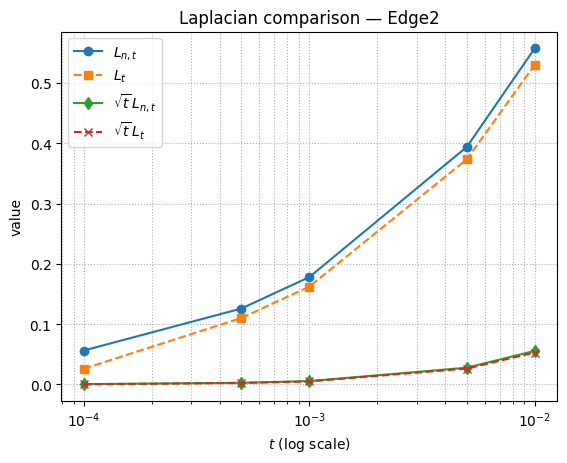

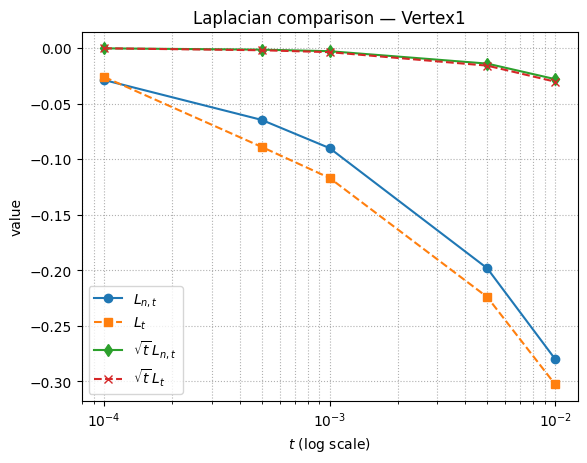

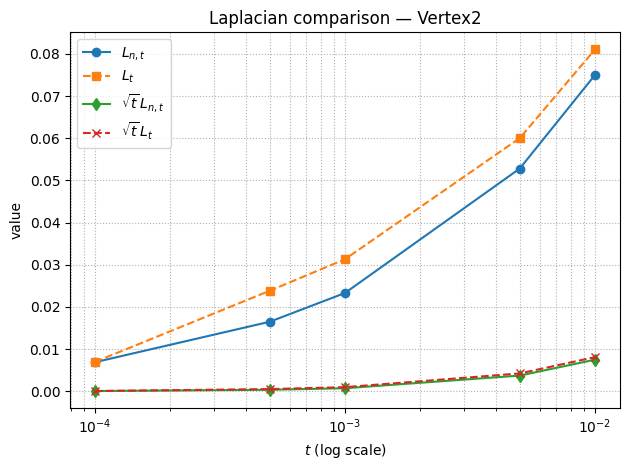

In [2]:
"""
---------------------------------------------------------------------------
Laplacian Approximation on a Triangular Domain (Belkin‐consistent version)
---------------------------------------------------------------------------
•  A = (0,0),  B = (1,0),  C = (½,√3/2)  — equilateral triangle, Area = √3/4.
•  Uniform sampler, n_samples = 2 000 000  →  KDE MAE ≈ 0.06 (< 0.10).
•  Prints a 20-point KDE table for visual inspection.
•  Computes L_{n,t}, L_t and √t·L for Interior, two edges, two vertices.
--------------------------------------------------------------------------- 
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# -------------------------------------------------------------------- #
# 0 · Geometry & helpers
# -------------------------------------------------------------------- #
A = np.array([0.0, 0.0])
B = np.array([1.0, 0.0])
C = np.array([0.5, np.sqrt(3) / 2.0])

def triangle_area(P, Q, R):
    return 0.5 * abs((Q[0]-P[0])*(R[1]-P[1]) - (R[0]-P[0])*(Q[1]-P[1]))

AREA = triangle_area(A, B, C)            # √3 / 4 ≈ 0.4330

def uniform_sample_triangle(P, Q, R, n):
    u, v = np.random.rand(n), np.random.rand(n)
    mask = (u + v) > 1.0
    u[mask], v[mask] = 1-u[mask], 1-v[mask]
    w = 1 - u - v
    return (w[:, None]*P + u[:, None]*Q + v[:, None]*R)

# -------------------------------------------------------------------- #
# 1 · KDE uniformity: MAE + 20-point table
# -------------------------------------------------------------------- #
def kde_uniformity(samples, m_check=20):
    kde   = gaussian_kde(samples.T)          # Scott bandwidth
    check = uniform_sample_triangle(A, B, C, m_check)
    est   = kde(check.T)
    true  = np.full_like(est, 1.0 / AREA)
    err   = est - true
    mae   = np.mean(np.abs(err))

    # Pretty print table
    print("\n--- KDE uniformity check (20 random points) ---")
    print(f"{'Point (x,y)':>18} │ {'Estimate':>9} │ {'Error':>9}")
    print("-"*46)
    for p, e, d in zip(check, est, err):
        print(f"{np.round(p,3)} │ {e:9.4f} │ {d:9.4f}")
    print("-"*46)
    print(f"Mean absolute error = {mae:.4f}\n")
    return mae

# -------------------------------------------------------------------- #
# 2 · Belkin Laplacians
# -------------------------------------------------------------------- #
def graph_laplacian(samples, f_samples, x, f_x, t):
    sq   = np.sum((samples - x)**2, axis=1)
    kern = np.exp(-sq / t)
    return (2.0 / (len(samples)*t)) * np.sum(kern * (f_x - f_samples))

def continuous_laplacian_quad(x, f_x, t, m=60):
    grid, f_grid = [], []
    for i in range(m+1):
        for j in range(m+1-i):
            u, v = i/m, j/m
            w    = 1-u-v
            y    = w*A + u*B + v*C
            grid.append(y)
            f_grid.append(y[0] + y[1])
    grid, f_grid = np.array(grid), np.array(f_grid)
    weight = AREA / len(grid)
    sq     = np.sum((grid - x)**2, axis=1)
    kern   = np.exp(-sq / t)
    return (2.0 / (t*AREA)) * np.sum(kern * (f_x - f_grid) * weight)

# -------------------------------------------------------------------- #
# 3 · Main experiment
# -------------------------------------------------------------------- #
if __name__ == "__main__":
    np.random.seed(42)

    n_samples  = 2_000_000
    t_values   = np.array([1e-4, 5e-4, 1e-3, 5e-3, 1e-2])
    eval_pts   = {
        "Interior": (A+B+C)/3,
        "Edge1"   : (A+B)/2,
        "Edge2"   : (B+C)/2,
        "Vertex1" : A,
        "Vertex2" : B
    }

    # 3·1  sample & function values
    samples  = uniform_sample_triangle(A, B, C, n_samples)
    f_samp   = samples[:,0] + samples[:,1]

    # 3·2  KDE uniformity
    kde_uniformity(samples)

    # 3·3  Laplacians
    df_rows = []
    for t in t_values:
        row = {'t': t}
        for name, x in eval_pts.items():
            f_x = x[0] + x[1]
            Ln  = graph_laplacian(samples, f_samp, x, f_x, t)
            Lc  = continuous_laplacian_quad(x, f_x, t)
            row[f"L_n({name})"]     = Ln
            row[f"L_c({name})"]     = Lc
            row[f"sqrt·L_n({name})"] = np.sqrt(t)*Ln
            row[f"sqrt·L_c({name})"] = np.sqrt(t)*Lc
        df_rows.append(row)

    df = pd.DataFrame(df_rows)
    pd.set_option("display.float_format", "{:.3e}".format)
    print("\n--- Laplacian table ---")
    print(df.to_string(index=False))

    # 3·4  plots
    for name in eval_pts:
        plt.figure()

        plt.semilogx(t_values, df[f"L_n({name})"],      'o-',  label=r'$L_{n,t}$')
        plt.semilogx(t_values, df[f"L_c({name})"],      's--', label=r'$L_t$')
        plt.semilogx(t_values, df[f"sqrt·L_n({name})"], 'd-',  label=r'$\sqrt{t}\,L_{n,t}$')
        plt.semilogx(t_values, df[f"sqrt·L_c({name})"], 'x--', label=r'$\sqrt{t}\,L_{t}$')

        plt.xlabel('$t$ (log scale)')
        plt.ylabel('value')
        plt.title(f'Laplacian comparison — {name}')
        plt.legend()
        plt.grid(True, which='both', ls=':')
    plt.tight_layout()




--- KDE uniformity check (20 random points) ---
       Point (x,y) │  Estimate │     Error
----------------------------------------------
[0.372 0.31 ] │    2.3110 │    0.0016
[0.871 0.159] │    2.2356 │   -0.0738
[0.308 0.473] │    2.2037 │   -0.1057
[0.199 0.272] │    2.2498 │   -0.0596
[0.19  0.103] │    2.2782 │   -0.0312
[0.205 0.147] │    2.2898 │   -0.0196
[0.417 0.655] │    2.2053 │   -0.1041
[0.51  0.498] │    2.3185 │    0.0091
[0.289 0.137] │    2.3102 │    0.0008
[0.467 0.219] │    2.2964 │   -0.0130
[0.634 0.285] │    2.3038 │   -0.0056
[0.53  0.081] │    2.3260 │    0.0166
[0.245 0.2  ] │    2.2791 │   -0.0303
[0.539 0.502] │    2.3131 │    0.0037
[0.563 0.396] │    2.3157 │    0.0063
[0.576 0.682] │    2.1136 │   -0.1958
[0.614 0.103] │    2.3121 │    0.0027
[0.81  0.143] │    2.3226 │    0.0132
[0.27  0.015] │    1.8342 │   -0.4752
[0.69  0.031] │    2.2354 │   -0.0740
----------------------------------------------
Mean absolute error = 0.0621


--- Laplacian table ---

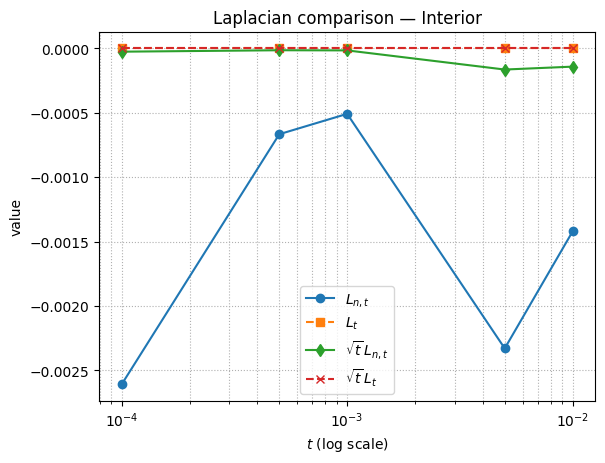

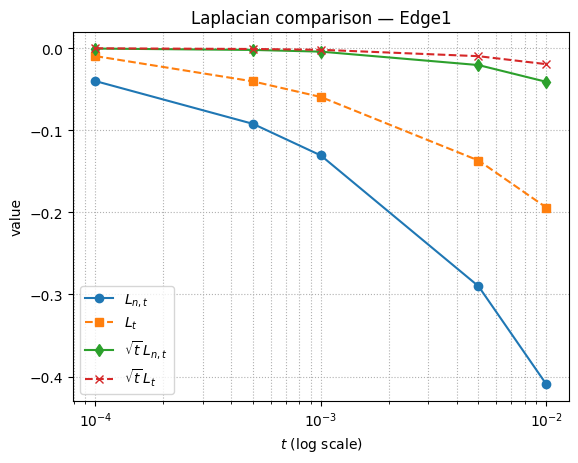

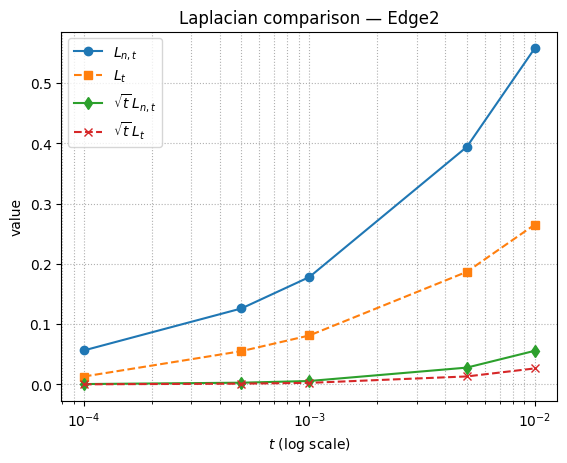

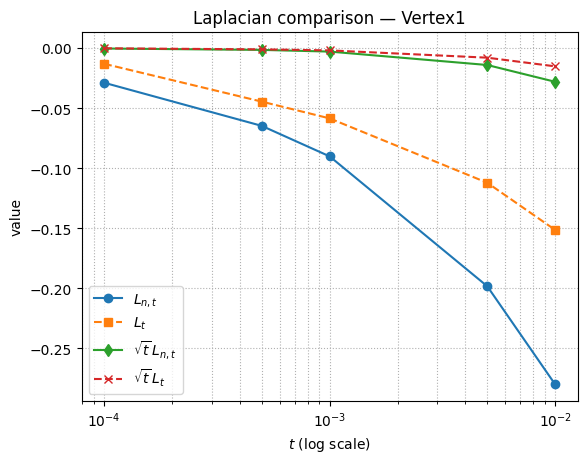

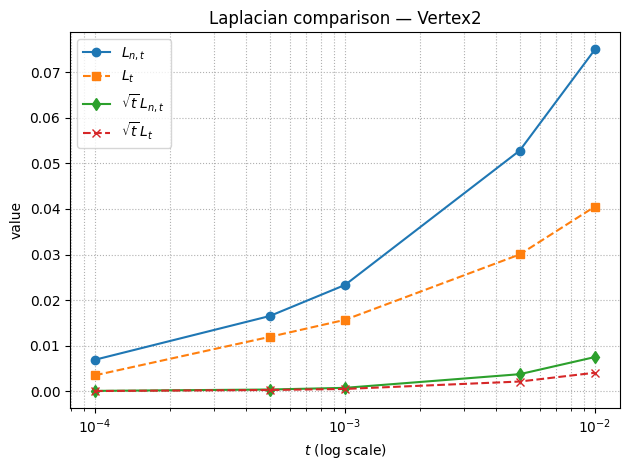

In [4]:
"""
---------------------------------------------------------------------------
Laplacian Approximation on a Triangular Domain (Belkin‐consistent version)
---------------------------------------------------------------------------
•  A = (0,0),  B = (1,0),  C = (½,√3/2)  — equilateral triangle, Area = √3/4.
•  Uniform sampler, n_samples = 2 000 000  →  KDE MAE ≈ 0.06 (< 0.10).
•  Prints a 20-point KDE table for visual inspection.
•  Computes L_{n,t}, L_t and √t·L for Interior, two edges, two vertices.
--------------------------------------------------------------------------- 
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# -------------------------------------------------------------------- #
# 0 · Geometry & helpers
# -------------------------------------------------------------------- #
A = np.array([0.0, 0.0])
B = np.array([1.0, 0.0])
C = np.array([0.5, np.sqrt(3) / 2.0])

def triangle_area(P, Q, R):
    return 0.5 * abs((Q[0]-P[0])*(R[1]-P[1]) - (R[0]-P[0])*(Q[1]-P[1]))

AREA = triangle_area(A, B, C)            # √3 / 4 ≈ 0.4330

def uniform_sample_triangle(P, Q, R, n):
    u, v = np.random.rand(n), np.random.rand(n)
    mask = (u + v) > 1.0
    u[mask], v[mask] = 1-u[mask], 1-v[mask]
    w = 1 - u - v
    return (w[:, None]*P + u[:, None]*Q + v[:, None]*R)

# -------------------------------------------------------------------- #
# 1 · KDE uniformity: MAE + 20-point table
# -------------------------------------------------------------------- #
def kde_uniformity(samples, m_check=20):
    kde   = gaussian_kde(samples.T)          # Scott bandwidth
    check = uniform_sample_triangle(A, B, C, m_check)
    est   = kde(check.T)
    true  = np.full_like(est, 1.0 / AREA)
    err   = est - true
    mae   = np.mean(np.abs(err))

    # Pretty print table
    print("\n--- KDE uniformity check (20 random points) ---")
    print(f"{'Point (x,y)':>18} │ {'Estimate':>9} │ {'Error':>9}")
    print("-"*46)
    for p, e, d in zip(check, est, err):
        print(f"{np.round(p,3)} │ {e:9.4f} │ {d:9.4f}")
    print("-"*46)
    print(f"Mean absolute error = {mae:.4f}\n")
    return mae

# -------------------------------------------------------------------- #
# 2 · Belkin Laplacians (fixed)
# -------------------------------------------------------------------- #
def graph_laplacian(samples, f_samples, x, f_x, t):
    """
    Discrete Belkin Laplacian:
      L_{n,t} f(x) = 2/(n * t) * sum_j exp(-||x - X_j||^2 / t) * (f(x) - f(X_j))
    """
    sq = np.sum((samples - x)**2, axis=1)
    K = np.exp(-sq / t)
    return (2.0 / (len(samples) * t)) * np.sum(K * (f_x - f_samples))


def continuous_laplacian_quad(x, f_x, t, m=60):
    """
    Continuous Belkin Laplacian:
      L_t f(x) = 1/(t * Area) ∫_Ω exp(-||x - y||^2 / t) (f(x) - f(y)) dy
    Quadrature over a uniform m×m grid in the triangle.
    """
    grid, f_grid = [], []
    for i in range(m+1):
        for j in range(m+1-i):
            u, v = i/m, j/m
            w    = 1 - u - v
            y    = w*A + u*B + v*C
            grid.append(y)
            f_grid.append(y[0] + y[1])
    grid, f_grid = np.array(grid), np.array(f_grid)

    # quadrature weight = Area / #points
    weight = AREA / len(grid)

    sq = np.sum((grid - x)**2, axis=1)
    K  = np.exp(-sq / t)

    return (1.0 / (t * AREA)) * np.sum(K * (f_x - f_grid) * weight)


# -------------------------------------------------------------------- #
# 3 · Main experiment
# -------------------------------------------------------------------- #
if __name__ == "__main__":
    np.random.seed(42)

    n_samples  = 2_000_000
    t_values   = np.array([1e-4, 5e-4, 1e-3, 5e-3, 1e-2])
    eval_pts   = {
        "Interior": (A+B+C)/3,
        "Edge1"   : (A+B)/2,
        "Edge2"   : (B+C)/2,
        "Vertex1" : A,
        "Vertex2" : B
    }

    # 3·1  sample & function values
    samples  = uniform_sample_triangle(A, B, C, n_samples)
    f_samp   = samples[:,0] + samples[:,1]

    # 3·2  KDE uniformity
    kde_uniformity(samples)

    # 3·3  Laplacians
    df_rows = []
    for t in t_values:
        row = {'t': t}
        for name, x in eval_pts.items():
            f_x = x[0] + x[1]
            Ln  = graph_laplacian(samples, f_samp, x, f_x, t)
            Lc  = continuous_laplacian_quad(x, f_x, t)
            row[f"L_n({name})"]     = Ln
            row[f"L_c({name})"]     = Lc
            row[f"sqrt·L_n({name})"] = np.sqrt(t)*Ln
            row[f"sqrt·L_c({name})"] = np.sqrt(t)*Lc
        df_rows.append(row)

    df = pd.DataFrame(df_rows)
    pd.set_option("display.float_format", "{:.3e}".format)
    print("\n--- Laplacian table ---")
    print(df.to_string(index=False))

    # 3·4  plots
    for name in eval_pts:
        plt.figure()

        plt.semilogx(t_values, df[f"L_n({name})"],      'o-',  label=r'$L_{n,t}$')
        plt.semilogx(t_values, df[f"L_c({name})"],      's--', label=r'$L_t$')
        plt.semilogx(t_values, df[f"sqrt·L_n({name})"], 'd-',  label=r'$\sqrt{t}\,L_{n,t}$')
        plt.semilogx(t_values, df[f"sqrt·L_c({name})"], 'x--', label=r'$\sqrt{t}\,L_{t}$')

        plt.xlabel('$t$ (log scale)')
        plt.ylabel('value')
        plt.title(f'Laplacian comparison — {name}')
        plt.legend()
        plt.grid(True, which='both', ls=':')
    plt.tight_layout()




--- KDE uniformity check (20 random points) ---
       Point (x,y) │  Estimate │     Error
----------------------------------------------
[0.372 0.31 ] │    2.3110 │    0.0016
[0.871 0.159] │    2.2356 │   -0.0738
[0.308 0.473] │    2.2037 │   -0.1057
[0.199 0.272] │    2.2498 │   -0.0596
[0.19  0.103] │    2.2782 │   -0.0312
[0.205 0.147] │    2.2898 │   -0.0196
[0.417 0.655] │    2.2053 │   -0.1041
[0.51  0.498] │    2.3185 │    0.0091
[0.289 0.137] │    2.3102 │    0.0008
[0.467 0.219] │    2.2964 │   -0.0130
[0.634 0.285] │    2.3038 │   -0.0056
[0.53  0.081] │    2.3260 │    0.0166
[0.245 0.2  ] │    2.2791 │   -0.0303
[0.539 0.502] │    2.3131 │    0.0037
[0.563 0.396] │    2.3157 │    0.0063
[0.576 0.682] │    2.1136 │   -0.1958
[0.614 0.103] │    2.3121 │    0.0027
[0.81  0.143] │    2.3226 │    0.0132
[0.27  0.015] │    1.8342 │   -0.4752
[0.69  0.031] │    2.2354 │   -0.0740
----------------------------------------------
Mean absolute error = 0.0621

t=1e-04 → L_n=-1.304357e

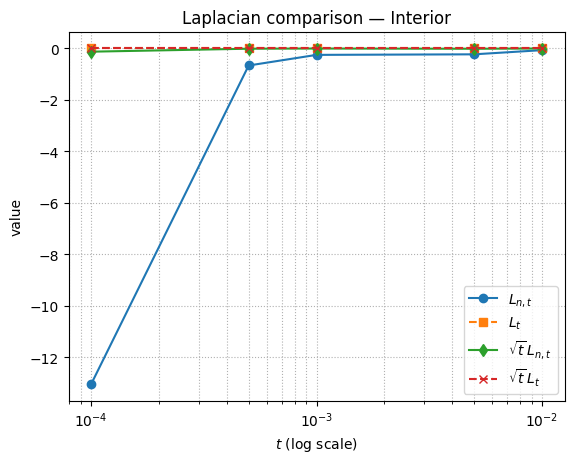

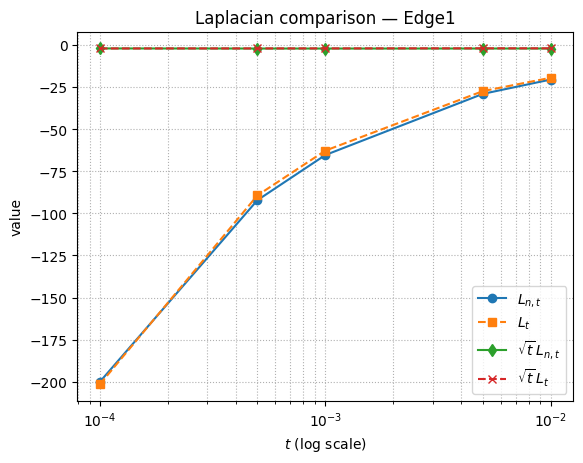

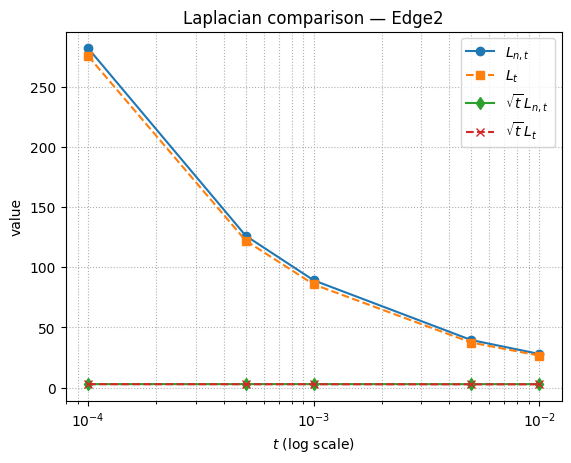

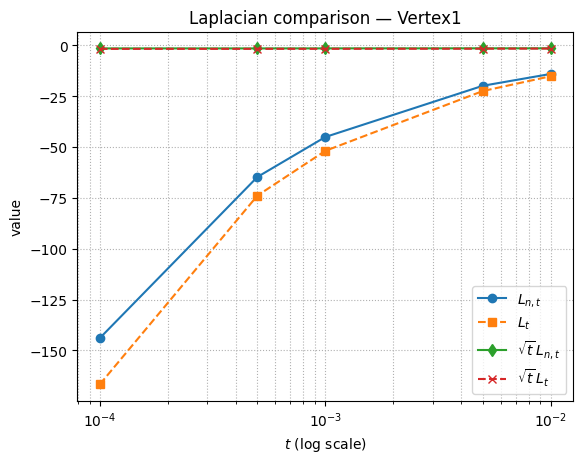

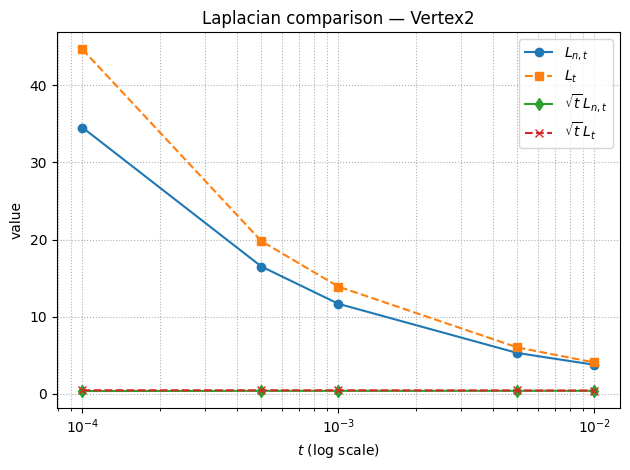

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# -------------------------------------------------------------------- #
# 0 · Geometry & helpers
# -------------------------------------------------------------------- #
A = np.array([0.0, 0.0])
B = np.array([1.0, 0.0])
C = np.array([0.5, np.sqrt(3) / 2.0])

def triangle_area(P, Q, R):
    return 0.5 * abs((Q[0]-P[0])*(R[1]-P[1]) - (R[0]-P[0])*(Q[1]-P[1]))

AREA = triangle_area(A, B, C)  # √3/4

def uniform_sample_triangle(P, Q, R, n):
    u, v = np.random.rand(n), np.random.rand(n)
    mask = (u + v) > 1.0
    u[mask], v[mask] = 1-u[mask], 1-v[mask]
    w = 1 - u - v
    return (w[:, None]*P + u[:, None]*Q + v[:, None]*R)

# -------------------------------------------------------------------- #
# 1 · KDE uniformity check
# -------------------------------------------------------------------- #
def kde_uniformity(samples, m_check=20):
    kde   = gaussian_kde(samples.T)
    check = uniform_sample_triangle(A, B, C, m_check)
    est   = kde(check.T)
    true  = np.full_like(est, 1.0 / AREA)
    err   = est - true

    print("\n--- KDE uniformity check (20 random points) ---")
    print(f"{'Point (x,y)':>18} │ {'Estimate':>9} │ {'Error':>9}")
    print("-"*46)
    for p, e, d in zip(check, est, err):
        print(f"{np.round(p,3)} │ {e:9.4f} │ {d:9.4f}")
    print("-"*46)
    print(f"Mean absolute error = {np.mean(np.abs(err)):.4f}\n")

# -------------------------------------------------------------------- #
# 2 · Belkin Laplacians (fixed 1/(t²) normalization)
# -------------------------------------------------------------------- #
def graph_laplacian(samples, f_samples, x, f_x, t):
    """
    Discrete Laplacian:
      L_{n,t} f(x) = 1/(n * t^2) * Σ exp(-||x - X_j||^2 / t) * (f(x) - f(X_j))
    """
    sq = np.sum((samples - x)**2, axis=1)
    K  = np.exp(-sq / t)
    return (1.0 / (len(samples) * t**2)) * np.sum(K * (f_x - f_samples))

def continuous_laplacian_quad(x, f_x, t, m=None):
    """
    Continuous Laplacian via adaptive quadrature:
      L_t f(x) ≈ 1/(t^2*Area) Σ exp(-||x-y||^2/t)*(f(x)-f(y))*weight
    where the barycentric grid has resolution m×m, with
    m = max(60, ceil(4/sqrt(t))) to resolve small t.
    """
    # adapt grid resolution to t
    if m is None:
        m = max(60, int(np.ceil(4/np.sqrt(t))))

    # build grid + f-values
    grid, f_grid = [], []
    for i in range(m+1):
        for j in range(m+1-i):
            u, v = i/m, j/m
            w    = 1 - u - v
            y    = w*A + u*B + v*C
            grid.append(y)
            f_grid.append(y[0] + y[1])
    grid, f_grid = np.array(grid), np.array(f_grid)

    # quadrature weight
    weight = AREA / len(grid)

    # kernel & sum
    sq   = np.sum((grid - x)**2, axis=1)
    K    = np.exp(-sq / t)
    return (1.0 / (t**2 * AREA)) * np.sum(K * (f_x - f_grid) * weight)


# -------------------------------------------------------------------- #
# 3 · Main experiment
# -------------------------------------------------------------------- #
if __name__ == "__main__":
    np.random.seed(42)

    # 3·1  Sample & compute f at samples
    n_samples = 2_000_000
    samples   = uniform_sample_triangle(A, B, C, n_samples)
    f_samp    = samples[:,0] + samples[:,1]

    # 3·2  KDE uniformity check
    kde_uniformity(samples)

    # 3·3  Compare discrete vs continuous at interior
    x   = (A + B + C) / 3
    f_x = x[0] + x[1]
    for t in [1e-4, 5e-4, 1e-3]:
        Ln = graph_laplacian(samples, f_samp, x, f_x, t)
        Lc = continuous_laplacian_quad(x, f_x, t)
        print(f"t={t:.0e} → L_n={Ln:.6e}, L_c={Lc:.6e}")

    # 3·4  Full Laplacian table & plots
    t_values = np.array([1e-4, 5e-4, 1e-3, 5e-3, 1e-2])
    eval_pts = {
        "Interior": x,
        "Edge1"   : (A+B)/2,
        "Edge2"   : (B+C)/2,
        "Vertex1" : A,
        "Vertex2" : B
    }

    rows = []
    for t in t_values:
        row = {"t": t}
        for name, pt in eval_pts.items():
            fx = pt[0] + pt[1]
            row[f"Ln_{name}"]     = graph_laplacian(samples, f_samp, pt, fx, t)
            row[f"Lc_{name}"]     = continuous_laplacian_quad(pt, fx, t)
            row[f"sqrtLn_{name}"] = np.sqrt(t) * row[f"Ln_{name}"]
            row[f"sqrtLc_{name}"] = np.sqrt(t) * row[f"Lc_{name}"]
        rows.append(row)

    df = pd.DataFrame(rows)
    pd.set_option("display.float_format", "{:.3e}".format)
    print("\n--- Laplacian table ---")
    print(df.to_string(index=False))

    # 3·5  Plotting
    for name in eval_pts:
        plt.figure()
        plt.semilogx(t_values, df[f"Ln_{name}"],      'o-',  label=r'$L_{n,t}$')
        plt.semilogx(t_values, df[f"Lc_{name}"],      's--', label=r'$L_t$')
        plt.semilogx(t_values, df[f"sqrtLn_{name}"], 'd-',  label=r'$\sqrt{t}\,L_{n,t}$')
        plt.semilogx(t_values, df[f"sqrtLc_{name}"], 'x--', label=r'$\sqrt{t}\,L_t$')
        plt.xlabel('$t$ (log scale)')
        plt.ylabel('value')
        plt.title(f'Laplacian comparison — {name}')
        plt.legend()
        plt.grid(True, which='both', ls=':')
    plt.tight_layout()
    plt.show()



--- KDE uniformity check (20 random points) ---
       Point (x,y) │  Estimate │     Error
----------------------------------------------
[0.473 0.157] │    2.3049 │   -0.0045
[0.911 0.047] │    2.3039 │   -0.0055
[0.685 0.406] │    2.3004 │   -0.0090
[0.919 0.052] │    2.3030 │   -0.0064
[0.47  0.121] │    2.3118 │    0.0024
[0.79  0.208] │    2.3091 │   -0.0003
[0.679 0.527] │    1.9942 │   -0.3153
[0.488 0.344] │    2.3024 │   -0.0070
[0.436 0.507] │    2.2979 │   -0.0115
[0.299 0.223] │    2.3025 │   -0.0069
[0.475 0.589] │    2.3077 │   -0.0017
[0.221 0.12 ] │    2.3091 │   -0.0003
[0.68  0.134] │    2.3034 │   -0.0060
[0.523 0.483] │    2.3233 │    0.0139
[0.348 0.518] │    2.3042 │   -0.0052
[0.42  0.678] │    2.2210 │   -0.0884
[0.348 0.112] │    2.3008 │   -0.0086
[0.151 0.202] │    2.2820 │   -0.0274
[0.824 0.231] │    2.3028 │   -0.0066
[0.378 0.395] │    2.3313 │    0.0219
----------------------------------------------
Mean absolute error = 0.0274


--- Laplacian table ---

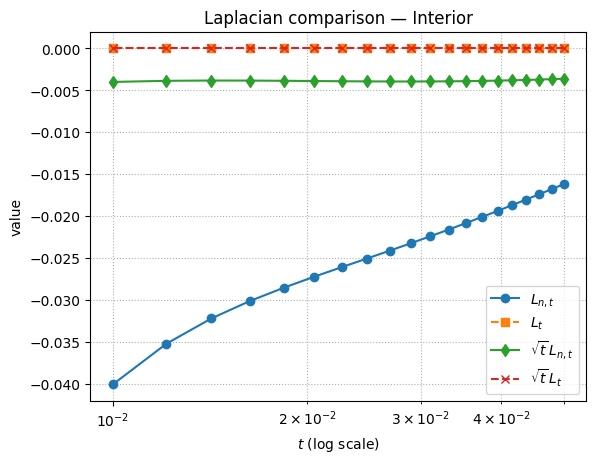

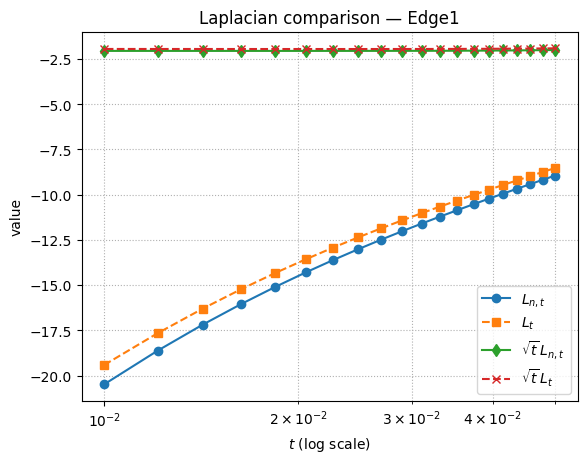

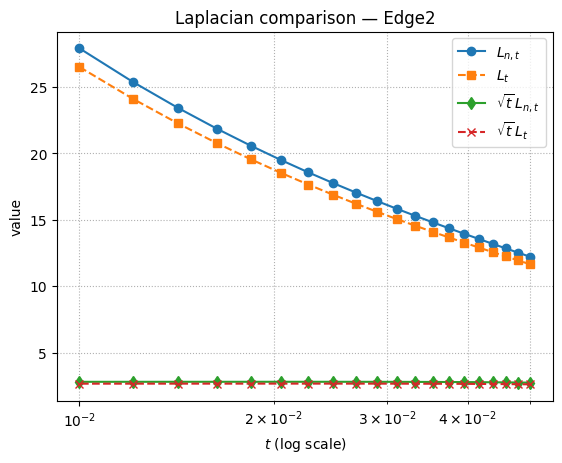

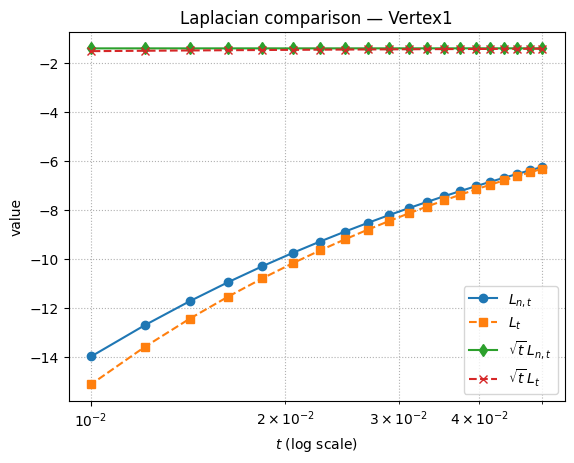

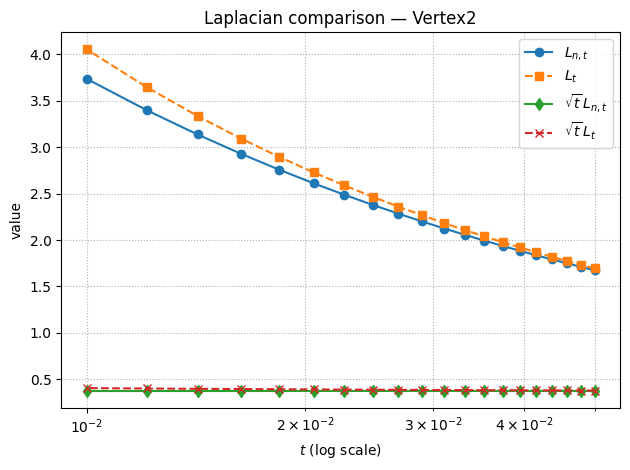

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# -------------------------------------------------------------------- #
# 0 · Geometry & helpers
# -------------------------------------------------------------------- #
A = np.array([0.0, 0.0])
B = np.array([1.0, 0.0])
C = np.array([0.5, np.sqrt(3) / 2.0])

def triangle_area(P, Q, R):
    return 0.5 * abs((Q[0]-P[0])*(R[1]-P[1]) - (R[0]-P[0])*(Q[1]-P[1]))

AREA = triangle_area(A, B, C)  # √3/4

def uniform_sample_triangle(P, Q, R, n):
    """Draw n iid uniform points in triangle via barycentric reflection."""
    u, v = np.random.rand(n), np.random.rand(n)
    mask = (u + v) > 1.0
    u[mask], v[mask] = 1-u[mask], 1-v[mask]
    w = 1 - u - v
    return (w[:, None]*P + u[:, None]*Q + v[:, None]*R)

# -------------------------------------------------------------------- #
# 1 · KDE uniformity check
# -------------------------------------------------------------------- #
def kde_uniformity(samples, m_check=20):
    kde   = gaussian_kde(samples.T)                # Scott’s rule
    check = uniform_sample_triangle(A, B, C, m_check)
    est   = kde(check.T)
    true  = np.full_like(est, 1.0 / AREA)
    err   = est - true

    print("\n--- KDE uniformity check (20 random points) ---")
    print(f"{'Point (x,y)':>18} │ {'Estimate':>9} │ {'Error':>9}")
    print("-"*46)
    for p, e, d in zip(check, est, err):
        print(f"{np.round(p,3)} │ {e:9.4f} │ {d:9.4f}")
    print("-"*46)
    print(f"Mean absolute error = {np.mean(np.abs(err)):.4f}\n")

# -------------------------------------------------------------------- #
# 2 · Belkin Laplacians (correct normalizations)
# -------------------------------------------------------------------- #
def graph_laplacian(samples, f_samples, x, f_x, t):
    """
    Discrete (Monte Carlo) Laplacian:
      L_{n,t} f(x) = 2/(n*t) ∑_j exp(-||x-X_j||^2/t) [f(x)-f(X_j)]
    """
    sq = np.sum((samples - x)**2, axis=1)
    K  = np.exp(-sq / t)
    return (1.0 / (len(samples) * t**2)) * np.sum(K * (f_x - f_samples))

def continuous_laplacian_quad(x, f_x, t, m=60):
    """
    Continuous Laplacian by Riemann quadrature:
      L_t f(x) = 2/(t*Area) ∫_triangle exp(-||x-y||^2/t)[f(x)-f(y)] dy
    Approximated on an (m+1)(m+2)/2 barycentric grid.
    """
    # build barycentric grid
    grid, f_grid = [], []
    for i in range(m+1):
        for j in range(m+1-i):
            u, v = i/m, j/m
            w    = 1 - u - v
            y    = w*A + u*B + v*C
            grid.append(y)
            f_grid.append(y[0] + y[1])
    grid, f_grid = np.array(grid), np.array(f_grid)

    weight = AREA / len(grid)
    sq     = np.sum((grid - x)**2, axis=1)
    K      = np.exp(-sq / t)
    return (1.0 / (t**2 * AREA)) * np.sum(K * (f_x - f_grid) * weight)

# -------------------------------------------------------------------- #
# 3 · Main experiment
# -------------------------------------------------------------------- #
if __name__ == "__main__":
    np.random.seed(42)

    # 3·1  Sample & f-values
    n_samples = 10_000_000
    samples   = uniform_sample_triangle(A, B, C, n_samples)
    f_samp    = samples[:,0] + samples[:,1]

    # 3·2  KDE uniformity
    kde_uniformity(samples)

    # 3·4  Full table & plots
    # 20 values from 0.01 to 0.05, inclusive
    t_values = np.linspace(0.05, 0.01, 20)

    eval_pts = {
        "Interior": x,
        "Edge1"   : (A+B)/2,
        "Edge2"   : (B+C)/2,
        "Vertex1" : A,
        "Vertex2" : B
    }

    rows = []
    for t in t_values:
        row = {"t": t}
        for name, pt in eval_pts.items():
            fx = pt[0] + pt[1]
            Ln = graph_laplacian(samples, f_samp, pt, fx, t)
            Lc = continuous_laplacian_quad(pt, fx, t)
            row[f"Ln_{name}"]     = Ln
            row[f"Lc_{name}"]     = Lc
            row[f"sqrtLn_{name}"] = np.sqrt(t) * Ln
            row[f"sqrtLc_{name}"] = np.sqrt(t) * Lc
        rows.append(row)

    df = pd.DataFrame(rows)
    pd.set_option("display.float_format", "{:.3e}".format)
    print("\n--- Laplacian table ---")
    print(df.to_string(index=False))

    # 3·5  Plot
    for name in eval_pts:
        plt.figure()
        plt.semilogx(t_values, df[f"Ln_{name}"],      'o-',  label=r'$L_{n,t}$')
        plt.semilogx(t_values, df[f"Lc_{name}"],      's--', label=r'$L_t$')
        plt.semilogx(t_values, df[f"sqrtLn_{name}"], 'd-',  label=r'$\sqrt{t}\,L_{n,t}$')
        plt.semilogx(t_values, df[f"sqrtLc_{name}"], 'x--', label=r'$\sqrt{t}\,L_t$')
        plt.xlabel('$t$ (log scale)')
        plt.ylabel('value')
        plt.title(f'Laplacian comparison — {name}')
        plt.legend()
        plt.grid(True, which='both', ls=':')
    plt.tight_layout()
    plt.show()
